# Integrative Analysis

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator

CELL_CHANGES = ["localization", "morphology"]
BIO_PLATE_MAP_BATCHES = ["2024_01_23_Batch_7", "2024_12_09_Batch_11", "2025_01_27_Batch_13", "2025_03_17_Batch_15"]
BIO_BATCHES = ["2024_02_Batch_7-8", "2024_12_Batch_11-12", "2025_01_Batch_13-14", "2025_03_Batch_15-16"]

# pl.Config.set_tbl_rows(20)  # Sets the number of rows displayed
# BIO_REP_BATCHES = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]
# COMBINED_BIO_REP_DIR = "2024_02_Batch_7-8"
# BIO_REP_BATCHES = ["2024_12_09_Batch_11", "2024_12_09_Batch_12"]
# COMBINED_BIO_REP_DIR = "2024_12_Batch_11-12"
# BIO_REP_BATCHES = ["2024_12_09_Batch_11_widefield", "2024_12_09_Batch_12_widefield"]
# COMBINED_BIO_REP_DIR = "2024_12_Batch_11-12_widefield"
# BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
# COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"
# BIO_REP_BATCHES = ["2025_03_17_Batch_15", "2025_03_17_Batch_16"]

## 1. Loading variants and ClinVar annotations

### 1.1 Variant info

In [164]:
profiled_variants_df, profiled_variants_pass_qc_df = pl.DataFrame(), pl.DataFrame()
for batch, batch_biorep in zip(BIO_PLATE_MAP_BATCHES, BIO_BATCHES):
    profiled_variants_df_batch = pl.DataFrame()
    platemap_dir = f"../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch}/platemap"
    for platemap in os.listdir(platemap_dir):
        platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
        profiled_variants_df_batch = pl.concat([profiled_variants_df_batch, 
                                                platemap_df.filter((~pl.col("node_type").is_in(["TC","NC","PC"]))&(pl.col("node_type").is_not_null()))], 
                                                how="diagonal_relaxed")
    
    ## load the img qc results
    allele_qc_df = pl.read_csv(f"../../outputs/{batch_biorep}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    # print(df_result)
    profiled_variants_pass_qc_df_batch = profiled_variants_df_batch.filter(
        (pl.col("gene_allele").is_in(df_result["gene_allele"]))
    )

    profiled_variants_df = pl.concat([profiled_variants_df, profiled_variants_df_batch], 
                                      how="diagonal_relaxed")
    profiled_variants_pass_qc_df = pl.concat([profiled_variants_pass_qc_df, profiled_variants_pass_qc_df_batch], 
                                      how="diagonal_relaxed")
        
profiled_variants_df = profiled_variants_df.drop(["control_type", "allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "hgmd_ID"])
profiled_variants_pass_qc_df = profiled_variants_pass_qc_df.drop(["control_type", "allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "hgmd_ID"])

In [165]:
# profiled_variants_df["node_type"].unique()
## All variants have a reference, yeah!
# [gene for gene in profiled_variants_pass_qc_df["gene_allele"].str.split("_").list.get(0) if gene not in profiled_variants_pass_qc_df["symbol"].unique()]

In [167]:
print(profiled_variants_df.unique(subset="gene_allele").filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).shape)
print(profiled_variants_pass_qc_df.unique(subset="gene_allele").filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).shape)

print(profiled_variants_df.unique(subset="symbol").shape)
print(profiled_variants_pass_qc_df.unique(subset="symbol").shape)

(1578, 33)
(1477, 33)
(349, 33)
(336, 33)


In [168]:
1477 / 1578, 336 / 349

(0.9359949302915083, 0.9627507163323782)

In [169]:
change_sum_local, change_sum_morph = pl.DataFrame(), pl.DataFrame()
change_wtvar = {}

for bio_batch in BIO_BATCHES:
    change_sum_local_batch = pl.read_csv(f"../../outputs/{bio_batch}/altered_local_summary_auroc.csv")
    change_sum_morph_batch = pl.read_csv(f"../../outputs/{bio_batch}/altered_morph_summary_auroc.csv")
    ## load the img qc results
    allele_qc_df = pl.read_csv(f"../../outputs/{bio_batch}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    # print(df_result)
    change_sum_local_batch = change_sum_local_batch.filter(
        (pl.col("allele_0").is_in(df_result["gene_allele"]))
    )
    change_sum_morph_batch = change_sum_morph_batch.filter(
        (pl.col("allele_0").is_in(df_result["gene_allele"]))
    )
    change_sum_local = pl.concat([change_sum_local, change_sum_local_batch], how="diagonal_relaxed")
    change_sum_morph = pl.concat([change_sum_morph, change_sum_morph_batch], how="diagonal_relaxed")

change_wtvar["localization"] = change_sum_local
change_wtvar["morphology"] = change_sum_morph

In [247]:
# clin_var_scores = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/3_integrated_assay_results/1_inputs/ai_pred_struc_scores.tsv", 
#                          separator="\t", infer_schema_length=10000)
# clin_var_scores = clin_var_scores.with_columns(
#     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("allele_0")
# )
# clin_var_scores.head()

clin_var_scores = pl.scan_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/4_compare_AI_scores/3_outputs/processed_data/dbnsfp/dbNSFP5.0a_variant.clin_var_re-annot_pdb_variants_plddt_rsa.parquet"
)
clin_var_scores = clin_var_scores.with_columns(
    pl.concat_str([pl.col("genename"), pl.col("clinvar_aa_change")], separator="_").alias("allele_0")
)
clin_var_scores = clin_var_scores.filter(pl.col("allele_0").is_in(profiled_variants_pass_qc_df["gene_allele"])).collect()
# clin_var_scores.collect()

# clin_var_scores

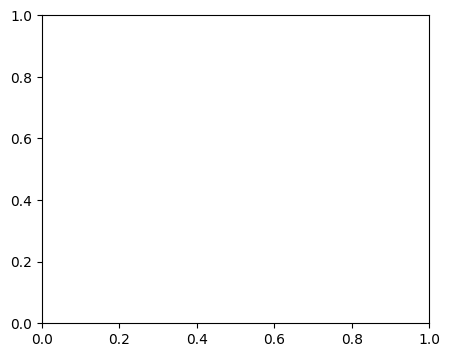

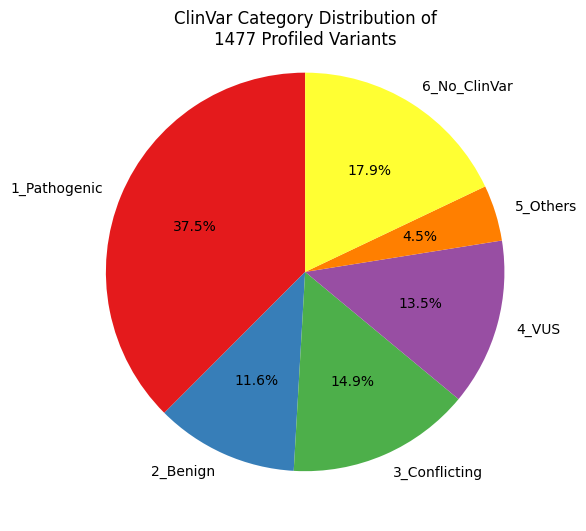

In [172]:
profiled_variants_df_clinvar = profiled_variants_pass_qc_df.join(
    clin_var_scores.select(
        pl.col(["allele_0","plddt","rsa","clinvar_clnsig_clean"])
    ).with_columns(
        pl.col("clinvar_clnsig_clean").cast(pl.String).alias("clinvar_clnsig_clean")
    ), 
    left_on="gene_allele", right_on="allele_0", how="left"
).filter(
    (pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol")) 
).with_columns(
    pl.col("clinvar_clnsig_clean").fill_null("6_No_ClinVar")
).unique(subset="gene_allele") ## get the unique alleles only

df = profiled_variants_df_clinvar.to_pandas()
df["symbol"] = df["gene_allele"].apply(lambda x: x.split("_")[0])

# Count category frequencies
counts = df["clinvar_clnsig_clean"].value_counts()

# Sort categories if you want specific order
category_order = sorted(df["clinvar_clnsig_clean"].unique())
counts = counts.reindex([cat for cat in category_order if cat in counts.index])

# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.get_cmap("Set1").colors[:len(counts)]
)
ax.set_title(f"ClinVar Category Distribution of\n{profiled_variants_df_clinvar.shape[0]} Profiled Variants",y=.94)
plt.tight_layout()
plt.show()

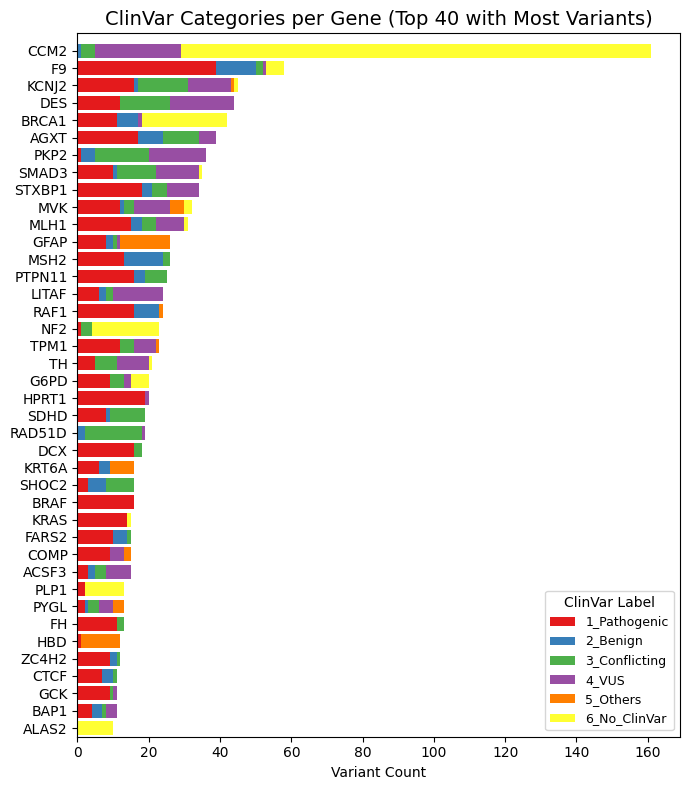

In [173]:
# 2. Count per (gene, category)
top_num = 40
counts = (
    df.groupby(["symbol", "clinvar_clnsig_clean"])
    .size()
    .reset_index(name="count")
)
# 3. Pivot
pivot = counts.pivot(index="symbol", columns="clinvar_clnsig_clean", values="count").fillna(0)

# Add total count column and sort by it (descending)
pivot["total_count"] = pivot.sum(axis=1)
pivot = pivot.sort_values("total_count", ascending=False).head(top_num)
pivot = pivot.drop(columns=["total_count"])

# 4. Ensure category order
for cat in category_order:
    if cat not in pivot.columns:
        pivot[cat] = 0
pivot = pivot[category_order]

# 5. Plotting
fig, ax = plt.subplots(figsize=(7, max(4, len(pivot)*0.2)))
# Get Set2 colors
colors = sns.color_palette("Set1", n_colors=len(category_order))
bottom = None
for cat, color in zip(category_order, colors):
    ax.barh(pivot.index, pivot[cat], left=bottom, label=cat, color=color)
    bottom = pivot[cat] if bottom is None else bottom + pivot[cat]
# Axis formatting
ax.set_xlabel("Variant Count")
ax.set_ylim(-1, pivot.shape[0] - .5)  # Tighten y-axis to remove top/bottom gaps
ax.set_title(f"ClinVar Categories per Gene (Top {top_num} with Most Variants)", fontsize=14)
ax.invert_yaxis()
ax.legend(title="ClinVar Label", fontsize=9, title_fontsize=10, loc="lower right")
plt.tight_layout()
plt.show()

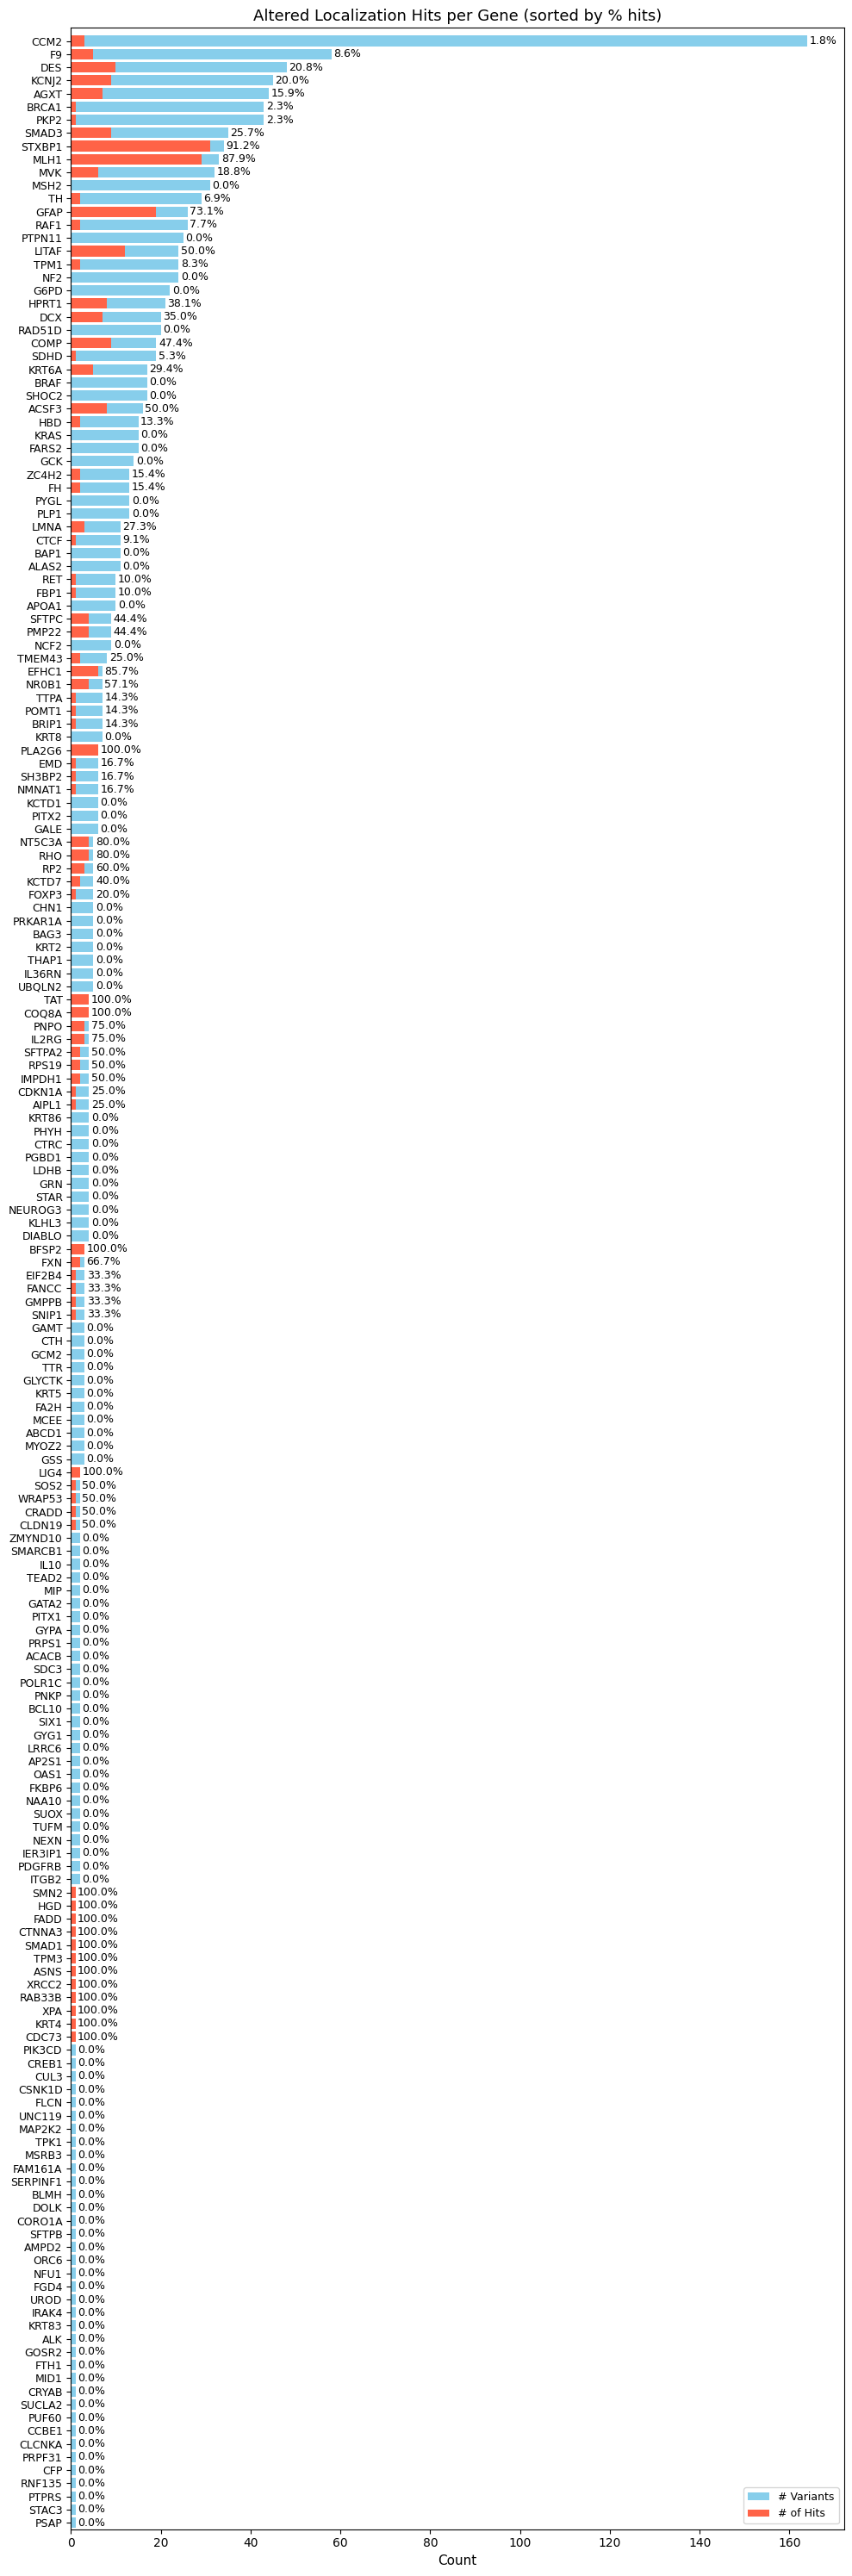

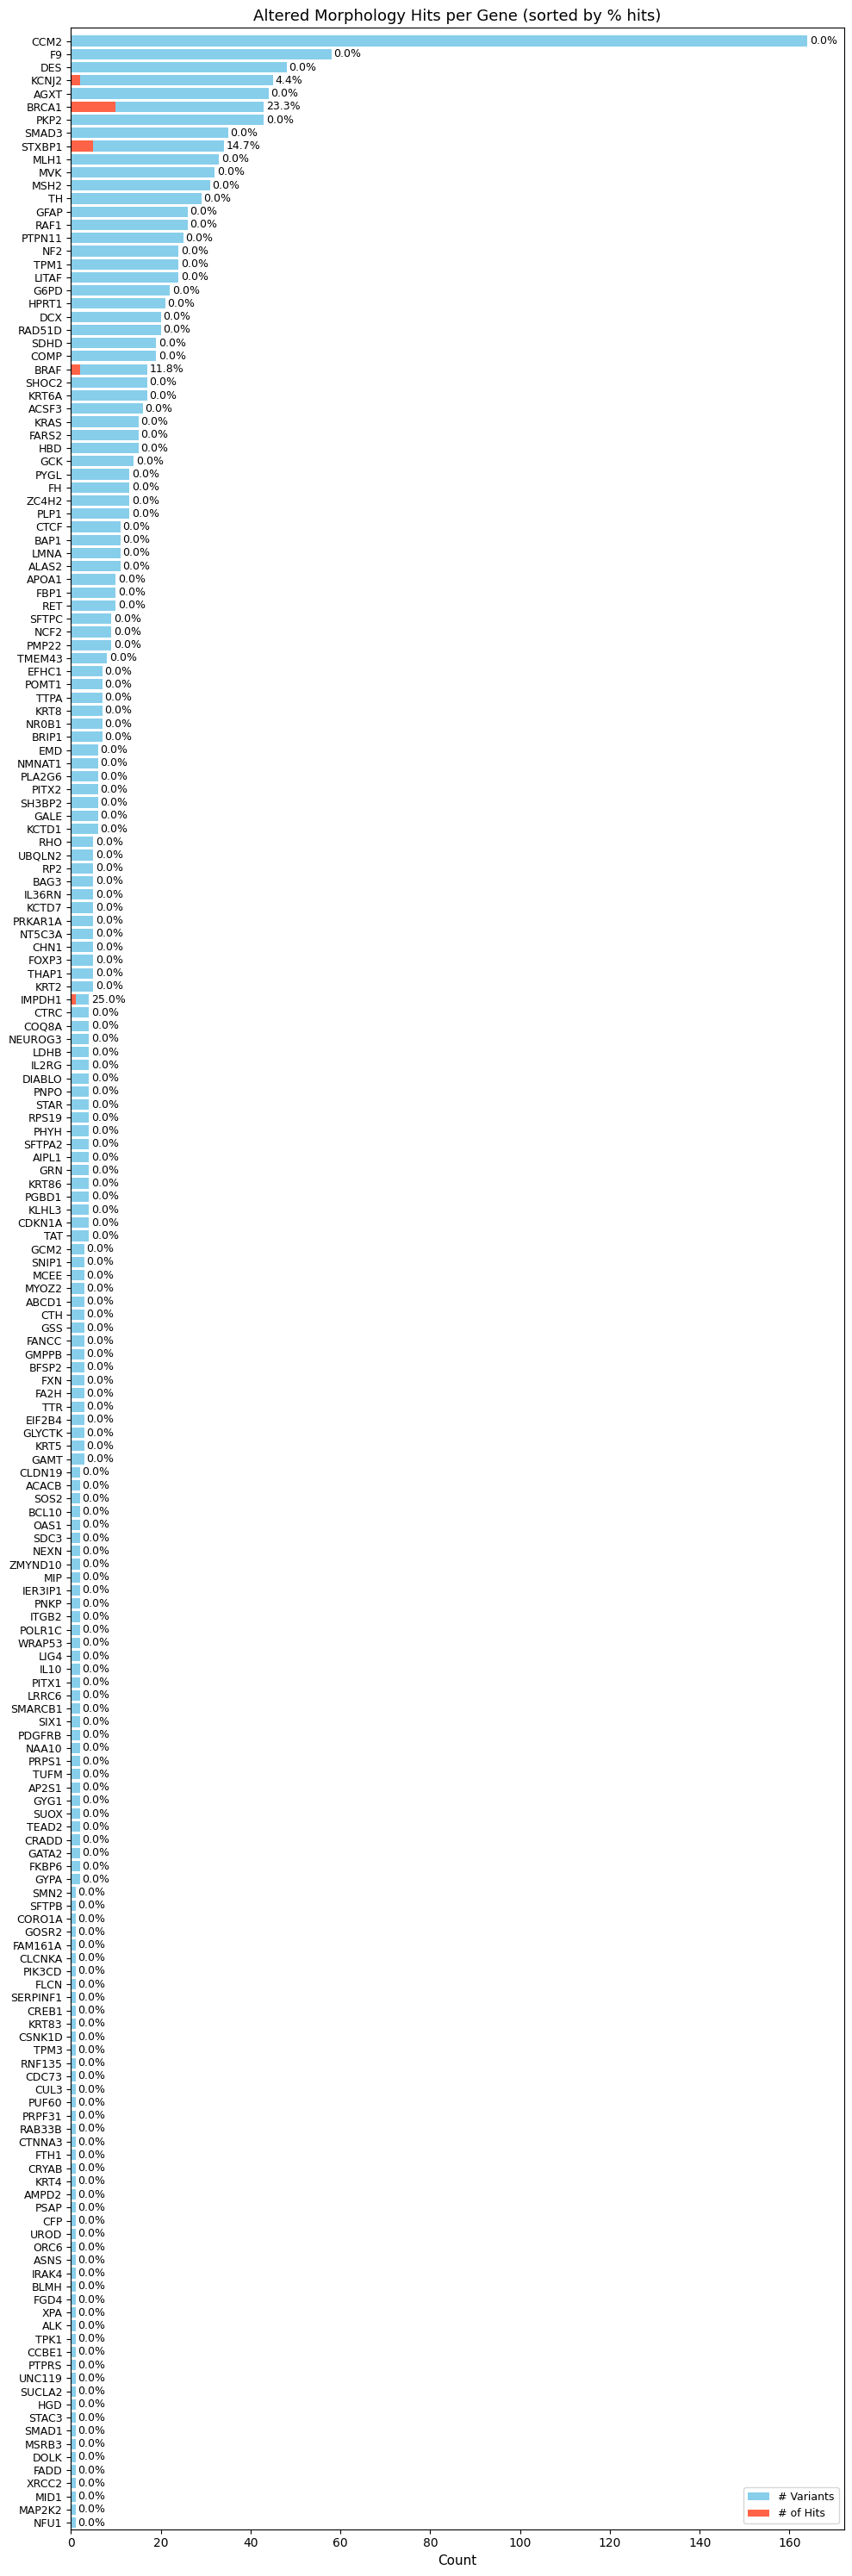

In [ ]:
# import plotly.express as px
# def interactive_gene_summary_barplot(df, cell_change):
#     df = df.copy()
#     df["pct_hits"] = df["len_hits"] / df["len"] * 100
#     df = df.sort_values(by=["len", "pct_hits"], ascending=False).reset_index(drop=True)

#     fig = px.bar(
#         df,
#         x="len",
#         y="by",
#         orientation="h",
#         color="len_hits",
#         hover_data=["len", "len_hits", "pct_hits"],
#         color_continuous_scale="RdBu",
#         labels={"by": "Gene", "len": "Total Variants", "len_hits": "Hits"},
#         title=f"Altered {cell_change.capitalize()} Hits per Gene (Interactive)"
#     )
#     fig.update_layout(
#         yaxis=dict(autorange="reversed"),
#         height=max(800, len(df)*10),
#         margin=dict(l=120, r=20, t=40, b=20),
#     )
#     fig.show()

def plot_gene_level_summary_horizontal(total_allele_hit_sum_df, cell_change):
    # 1. Fill nulls with 0
    total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)

    # 2. Compute percentage of hits
    total_allele_hit_sum_df["pct_hits"] = (
        total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
    )

    # 3. Sort by percentage descending
    total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(
        by=["len", "pct_hits"], ascending=False
    ).reset_index(drop=True)

    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_height = 0.6
    fig_height = max(6, min(n_genes * 0.45, 30))  # cap to prevent overgrowth
    fig_width = 10
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Horizontal bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percent
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            va="center",
            ha="left",
            fontsize=9,
        )

    # Axis formatting
    ax.set_yticks(y)
    ax.set_ylim(-1, len(y) - .5)  # Tighten y-axis to remove top/bottom gaps
    ax.set_yticklabels(total_allele_hit_sum_df["by"], fontsize=9)
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"Altered {cell_change.capitalize()} Hits per Gene (sorted by % hits)",
        fontsize=13
    )
    ax.invert_yaxis()  # Highest hit on top
    ax.legend(fontsize=9, loc="lower right")
    # Improve spacing
    plt.tight_layout()
    plt.show()


for cell_change in CELL_CHANGES:
    total_allele_hit_sum_df = profiled_variants_df.filter(pl.col("node_type")=="allele").unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
        change_wtvar[cell_change].filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")).with_columns(
            pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
        ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left"
    ).to_pandas()
    plot_gene_level_summary_horizontal(total_allele_hit_sum_df, cell_change)

## 2. Loading cell profiles

In [174]:
BATCH_LIST_DICT = {
    "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}

In [175]:
# Paths
pass_qc_prof_pq_path = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
ref_allele_cell_qc_profile_df = pl.DataFrame()

# Get meta features
for batch_id in BATCH_LIST_DICT.keys():
    batch_alleles = (
        pl.scan_parquet(
            pass_qc_prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(profiled_variants_pass_qc_df["gene_allele"].unique()))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
        .select([
            "Metadata_CellID",
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
            "Metadata_node_type"
        ])
    )
    ref_allele_cell_qc_profile_df = pl.concat([ref_allele_cell_qc_profile_df, batch_alleles.collect()])

In [176]:
# Paths
prof_pq_path = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
ref_allele_cell_all_profiles = []

# Get meta features
for batch_id in BATCH_LIST_DICT.keys():
    batch_alleles = (
        pl.scan_parquet(
            prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(profiled_variants_pass_qc_df["gene_allele"].unique()))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
    )
    ref_allele_cell_all_profiles.append(batch_alleles)
    
gfp_feats = [i for i in ref_allele_cell_all_profiles[0].collect_schema() if "GFP" in i and "Brightfield" not in i]
gfp_feats = ["Metadata_CellID"] + gfp_feats

ref_allele_cell_profile_all_df = pl.concat([batch_alleles.select(gfp_feats).collect() for batch_alleles in ref_allele_cell_all_profiles])
# This method of joining ensures that only cells past filters are included in the abundance analysis
ref_allele_cell_profile_df = ref_allele_cell_qc_profile_df.join(ref_allele_cell_profile_all_df.select(gfp_feats), on="Metadata_CellID", how="left")

In [ ]:
def remove_corr_feats(df, corr_thres=.8):
    # 2. Identify numeric columns
    all_num_feats = [
        name
        for name, dtype in df.schema.items()
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    ]
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)

    # colocal_col_cat = set(["_".join(col.split('_')[1:3]) for col in colocal_cols])
    # print(colocal_col_cat)
    # colocal_col_dict = defaultdict(list)
    # for col in colocal_cols:
    #     colocal_col_dict["_".join(col.split('_')[1:3])].append(col)
    # colocal_col_dict

    return df_drop_corr_cols


ref_allele_well_profile_df = (
    ref_allele_cell_profile_df.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in ref_allele_cell_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

ref_allele_well_profile_df = ref_allele_well_profile_df.with_columns(
    pl.col("Metadata_Plate")
      # capture a “B” followed by any non-underscore chars up to the first “A”
      .str.extract(r"(B[^_]*?A)", 1)
      .alias("Metadata_Batch")
).drop_nulls()

ref_allele_well_profile_df = remove_corr_feats(ref_allele_well_profile_df)
# ref_allele_well_profile_df.filter(pl.col("Metadata_Plate").str.contains("B11"))

## 3. Loading subcell compartment per gene

In [2]:
hpa_subcell_loc = pl.read_csv("/home/shenrunx/data_storage/igvf/varchamp/subcellular_localization/hpa_subcellular_location_annotations/subcellular_location_data.tsv", separator="\t")
hpa_subcell_loc = hpa_subcell_loc.with_columns(
    pl.when(pl.col("Main location").str.contains(";"))
    .then(pl.lit("Multiple"))
    .otherwise(pl.col("Main location"))
    .alias("Subcell_Loc")
)
hpa_subcell_loc_main = hpa_subcell_loc.filter(
    (pl.col("Subcell_Loc")!="Multiple")&(pl.col("Additional location").is_null()&(pl.col("Reliability")=="Approved"))
)

hpa_genes = hpa_subcell_loc["Gene name"]
# hpa_genes

# Read a JSON file into a pandas DataFrame
cd_code_json_file_path = "/home/shenrunx/data_storage/igvf/varchamp/subcellular_localization/cd-code/dataset.json"
cd_code_df = pd.read_json(cd_code_json_file_path)
# display(cd_code_df.head())
# 1. normalize into a new DataFrame
cell_compart_labels = pd.json_normalize(cd_code_df["labels"])#.dropna(how="all")
# display(cell_compart_labels)
## 2. drop the labels
cd_code_df = pd.concat([cd_code_df, cell_compart_labels], axis=1)
cd_code_df = cd_code_df.dropna(subset=["gene_names"]).drop(columns=["labels"])
cd_code_df = cd_code_df[cd_code_df["gene_names"]!=""]
cd_code_df.sort_values(by="gene_names")

,gene_names,entry,sequence,idrs,split,FCR_SUM,FCR_MEAN,NCPR_SUM,NCPR_MEAN,ISO,...,lysosome,rna_granule,endoplasmic_reticulum,vesicles,,nuclear_speckles,pbody,pml_body,post_synaptic_density,transcriptional
1829,A3G,U5KJ79_HUMAN,MKPHFRNTVERMYRDTFSYNFYNRPILSRRNTVWLCYEVKTKGPSR...,"[PLDA, CQK]",dev,94.428571,0.245908,5.857143e+00,1.525298e-02,8.31250,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1238,AAAS,AAAS_HUMAN,MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...,"[CSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPP, DPLKTPGRL...",train,88.000000,0.161172,4.440892e-16,8.133502e-19,7.87500,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1272,AATF,AATF_HUMAN,MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGEDG...,[MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGED...,train,195.714286,0.349490,-3.771429e+01,-6.734694e-02,4.59375,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
64,ABCC5,MRP5_HUMAN,MKDIDIGKEYIIPSPGYRSVRERTSTSGTHRDREDSKFRRTRPLEC...,[DIDIGKEYIIPSPGYRSVRERTSTSGTHRDREDSKFRRTRPLECQ...,train,314.571429,0.218908,1.628571e+01,1.133313e-02,8.75000,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1275,ABI2,ABI2_HUMAN,MAELQMLLEEEIPGGRRALFDSYTNLERVADYCENNYIQSADKQRA...,"[QMLLE, RRALFDS, CENNYIQSADKQRALEETKAY, ASQLRR...",train,95.571429,0.186299,-5.571429e+00,-1.086048e-02,6.12500,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,ZWILCH,H3BSG1_HUMAN,MAHNPNMTHLKINLPVTALPPLWVRCDSSDPEGTCWLGAELITTNN...,[MAHNPNMTHLKI],train,14.000000,0.166667,2.000000e+00,2.380952e-02,8.75000,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
168,ZWINT,ZWINT_HUMAN,MEAAETEAEAAALEVLAEVAGILEPVGLQEEAELPAKILVEFVVDS...,"[MEAAETEAEAA, AQEDTAKGLDPLASEDTSRQKAIAAKEQWKEL...",train,82.714286,0.298608,-8.714286e+00,-3.145952e-02,4.81250,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
592,ZYX,ZYX_HUMAN,MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEP...,[MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSE...,train,103.285714,0.180569,-6.714286e+00,-1.173826e-02,6.56250,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2547,dJ402G11.9,Q6ICA1_HUMAN,MYVPALGWEFLASTRLTSELNFLLQEIDNCYHRAAEGRAPKIEKQI...,"[EGRAPKIEKQIQSKGPGITEREKREIIENAEKEKSPEQNLFEK, ...",train,125.285714,0.230729,8.714286e+00,1.604841e-02,8.75000,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# hpa_subcell_loc#[hpa_subcell_loc["gene_names"]=="FARS2"]
# hpa_subcell_loc.filter(
#     (pl.col("Gene name")=="FARS2")
# )
# cd_code_df[cd_code_df["gene_names"]=="FARS2"]

In [231]:
ref_allele_well_profile_df_hpa = ref_allele_well_profile_df.join(
    hpa_subcell_loc_main.with_columns(
        pl.col("Gene name").alias("Metadata_genename_hpa"),
        pl.col("Subcell_Loc").alias("Metadata_Subcell_Loc"),
    ).select(pl.col(["Metadata_genename_hpa", "Metadata_Subcell_Loc"])), 
    left_on="Metadata_gene_allele", right_on="Metadata_genename_hpa",
    how="left"
)

ref_allele_well_profile_df_hpa.drop_nulls(subset="Metadata_Subcell_Loc")

# ref_allele_well_profile_df_hpa.filter(pl.col("Metadata_Plate").str.contains("B11"))

Metadata_Plate,Metadata_Well,Metadata_gene_allele,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,Cytoplasm_Correlation_K_AGP_GFP,Cytoplasm_Correlation_K_GFP_AGP,Cytoplasm_Correlation_K_GFP_DNA,Cytoplasm_Correlation_K_GFP_Mito,Cytoplasm_Correlation_Manders_AGP_GFP,Cytoplasm_Correlation_Manders_GFP_AGP,Cytoplasm_Correlation_Manders_GFP_DNA,Cytoplasm_Correlation_Manders_GFP_Mito,Cytoplasm_Correlation_Overlap_AGP_GFP,Cytoplasm_Correlation_Overlap_DNA_GFP,Cytoplasm_Correlation_RWC_GFP_AGP,Cytoplasm_Correlation_RWC_GFP_DNA,Cytoplasm_Granularity_10_GFP,Cytoplasm_Granularity_11_GFP,Cytoplasm_Granularity_12_GFP,Cytoplasm_Granularity_13_GFP,Cytoplasm_Granularity_14_GFP,Cytoplasm_Granularity_15_GFP,Cytoplasm_Granularity_16_GFP,Cytoplasm_Granularity_1_GFP,Cytoplasm_Granularity_2_GFP,Cytoplasm_Granularity_4_GFP,Cytoplasm_Intensity_IntegratedIntensityEdge_GFP,Cytoplasm_Intensity_MassDisplacement_GFP,Cytoplasm_Intensity_MinIntensityEdge_GFP,Cytoplasm_Location_CenterMassIntensity_X_GFP,Cytoplasm_Location_CenterMassIntensity_Y_GFP,Cytoplasm_Location_CenterMassIntensity_Z_GFP,Cytoplasm_Location_MaxIntensity_Z_GFP,Cytoplasm_RadialDistribution_FracAtD_GFP_10of10,Cytoplasm_RadialDistribution_FracAtD_GFP_1of10,Cytoplasm_RadialDistribution_FracAtD_GFP_9of10,Cytoplasm_RadialDistribution_MeanFrac_GFP_10of10,Cytoplasm_RadialDistribution_MeanFrac_GFP_9of10,Cytoplasm_Texture_Correlation_GFP_10_00_256,Cells_Correlation_K_GFP_DNA,Cells_Correlation_Manders_GFP_DNA,Cells_Correlation_Overlap_DNA_GFP,Cells_Granularity_4_GFP,Cells_Location_CenterMassIntensity_Z_GFP,Cells_Location_MaxIntensity_Z_GFP,Cells_RadialDistribution_FracAtD_GFP_10of10,Cells_RadialDistribution_FracAtD_GFP_1of10,Cells_RadialDistribution_FracAtD_GFP_8of10,Cells_RadialDistribution_MeanFrac_GFP_8of10,Nuclei_Correlation_Costes_AGP_GFP,Nuclei_Correlation_Costes_GFP_DNA,Nuclei_Correlation_Costes_GFP_Mito,Nuclei_Correlation_Manders_GFP_AGP,Nuclei_Correlation_Manders_GFP_DNA,Nuclei_Correlation_Manders_GFP_Mito,Nuclei_Correlation_Overlap_GFP_Mito,Nuclei_Correlation_RWC_GFP_AGP,Nuclei_Correlation_RWC_GFP_Mito,Nuclei_Granularity_5_GFP,Nuclei_Location_CenterMassIntensity_Z_GFP,Nuclei_Location_MaxIntensity_Z_GFP,Nuclei_Texture_Correlation_GFP_20_00_256,Metadata_Batch,Metadata_Subcell_Loc
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""2024_01_17_B7A1R1_P2T4""","""J14""","""LDLRAP1""",0.444374,0.339227,0.757157,1.0,1.0,1.0,1.0,1.0,1.0,2.091823,0.398305,0.180697,3.230816,0.944421,1.0,1.0,0.845583,0.927529,0.920579,0.708307,0.506948,3.124883,3.619101,1.740436,1.97362,0.471503,0.352372,0.000016,15.771171,0.721017,1.463631,4.581618,4.770372,0.001928,535.758345,561.703817,0.0,0.0,0.424378,0.002755,0.23623,0.939761,1.011141,0.510035,0.59055,0.327969,0.94245,2.367801,0.0,0.0,0.180287,0.006993,0.161664,1.045311,1.0,1.0,1.0,1.0,1.0,1.0,0.983615,0.736172,0.763595,4.924509,0.0,0.0,-0.043131,"""B7A""","""Microtubules"""
"""2024_02_05_B8A1R2_P4T3""","""D21""","""ZNF624""",0.115182,0.163213,0.353714,0.626059,0.814964,0.997703,0.264761,0.801869,0.763361,0.444033,2.137694,1.150901,21.927644,1.0,1.0,1.0,0.804025,0.974162,0.987953,0.735517,0.76906,1.653374,0.935855,0.59196,0.199135,0.00115,0.559582,0.242564,82.699962,1.005932,0.845996,1.152374,0.404068,0.001435,464.445303,666.777396,0.0,0.0,0.5776391,0.002082,0.176807,0.995431,1.003312,1.0,1.545791,1.0,0.909074,0.903026,0.0,0.0,0.3370438,0.00407,0.142884,1.009798,0.735616,1.0,1.0,1.0,1.0,1.0,0.979117,0.714505,0.67042,1.055953,0.0,0.0,

8


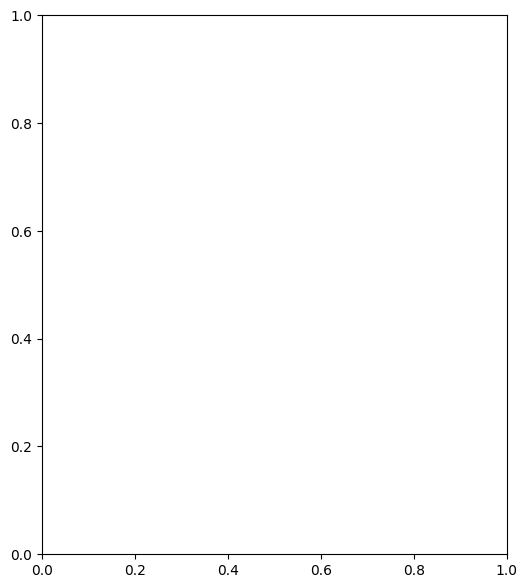

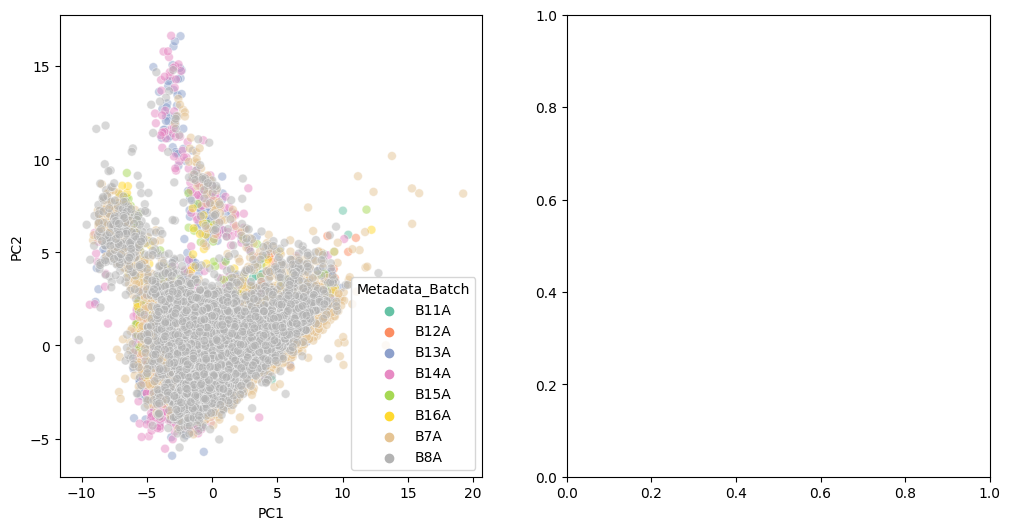

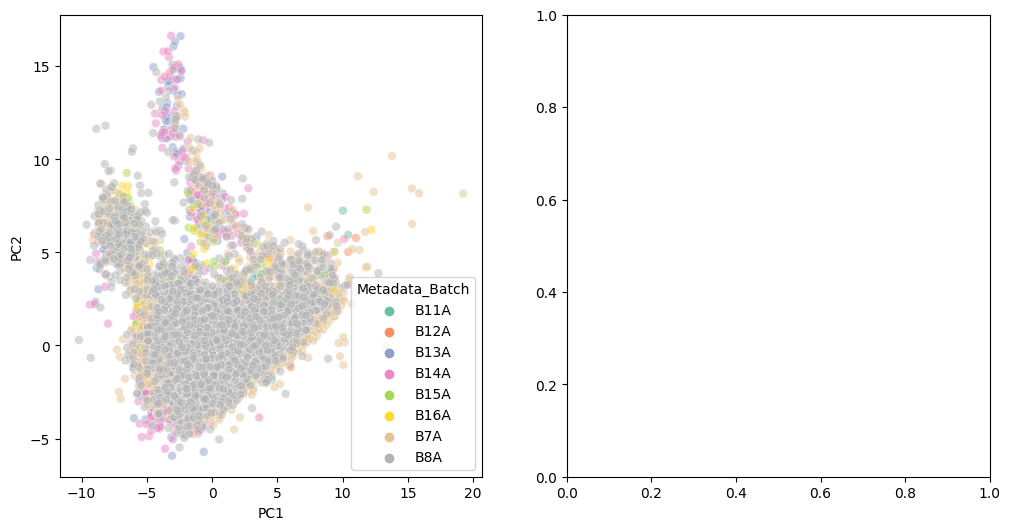

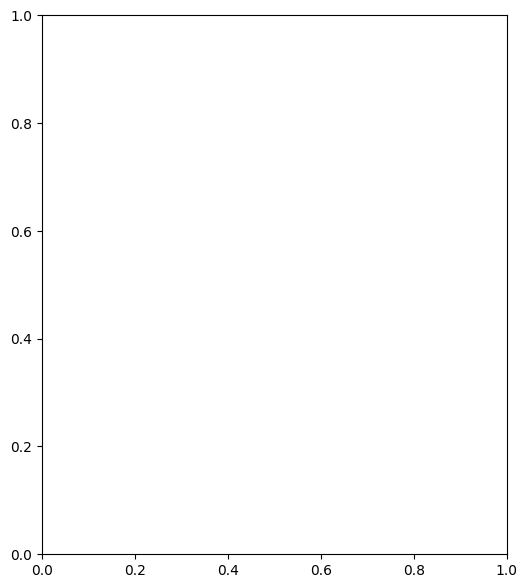

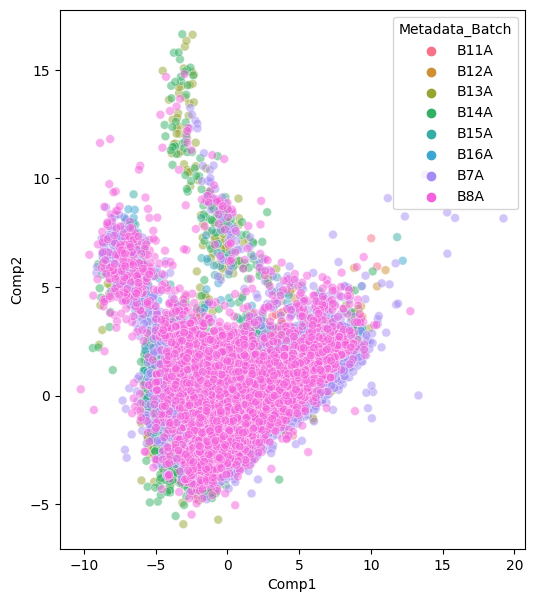

15


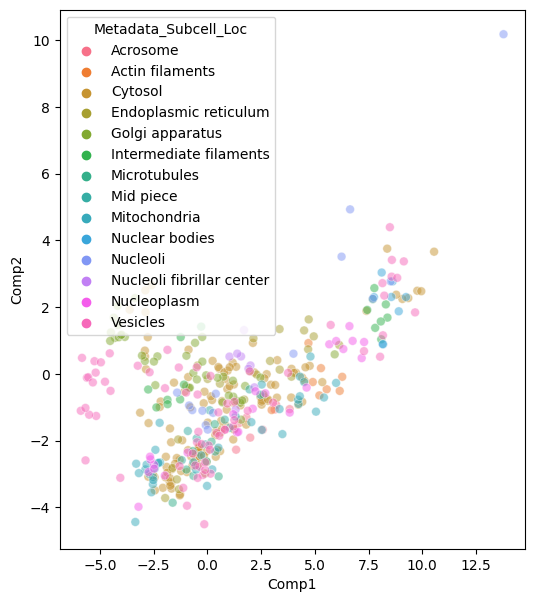

In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_dr(df, dr_method, standardize=True, ax=None, dr_args={}, plot_args={}):
    df_val = df.select(pl.col([col for col in df.columns if not col.startswith("Metadata_")]))#.drop_nulls()
    if standardize:
        # Standardize the features before PCA
        scaler = StandardScaler()
        df_val = pd.DataFrame(scaler.fit_transform(df_val), columns=df_val.columns)

    if dr_method=="pca":
        pca = PCA(**dr_args) #n_components=10
        dr_result = pca.fit_transform(df_val)
    if dr_method=="umap":
        # Perform UMAP
        umap_model = umap.UMAP(**dr_args) ## n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1
        dr_result = umap_model.fit_transform(df_val.to_numpy())

    dr_res_df = pd.DataFrame(dr_result, columns=[f"Comp{i+1}" for i in range(dr_result.shape[1])])
    for key in ["hue", "style", "size"]:
        if key in plot_args and plot_args[key] in df.columns:
            dr_res_df[plot_args[key]] = df[plot_args[key]].to_numpy()

    if ax is None:
        # Plot UMAP
        fig, ax = plt.subplots(1, 1, figsize=(6, 7))

    print(len(dr_res_df[plot_args["hue"]].unique()))
    sns.scatterplot(data=dr_res_df.sort_values(by=plot_args["hue"]), alpha=.5,
                    x="Comp1", y="Comp2",
                    palette=sns.color_palette("husl", len(dr_res_df.dropna(subset=plot_args["hue"])[plot_args["hue"]].unique())),#, 
                    s=40, ax=ax, **plot_args)
    plt.show()
    # ax[1].legend(ncol=2, title="Metadata_Batch")

plot_dr(ref_allele_well_profile_df_hpa, "pca", dr_args={"n_components": 10}, plot_args={"hue": "Metadata_Batch"})
plot_dr(ref_allele_well_profile_df_hpa, "pca", dr_args={"n_components": 10}, plot_args={"hue": "Metadata_Subcell_Loc"})

In [242]:
# Perform UMAP
# Perform PCA
df = ref_allele_well_profile_df_hpa.select(pl.col([col for col in ref_allele_well_profile_df_hpa.columns if not col.startswith("Metadata_")]))

# Standardize the features before PCA
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(df)

pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pca_df["Metadata_Subcell_Loc"] = ref_allele_well_profile_df_hpa["Metadata_Subcell_Loc"].to_numpy()
pca_df["Metadata_Batch"] = ref_allele_well_profile_df_hpa["Metadata_Batch"].to_numpy()
# pca_df["Metadata_variant_type"] = misloc_allele_well_profile_gfp_nocorr["Metadata_variant_type"].to_numpy()
# pca_df["Metadata_control_type"] = misloc_allele_well_profile_gfp_nocorr["Metadata_control_type"].to_numpy()

# Plot UMAP
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=pca_df.sort_values(by="Metadata_Batch"), alpha=.5,
                x="PC1", y="PC2", hue="Metadata_Batch", palette="Set2", s=40, ax=ax[0]) ## hue=variant_type, 
sns.scatterplot(data=pca_df.sort_values(by="Metadata_Subcell_Loc"), alpha=.5,
                x="PC1", y="PC2", hue="Metadata_Subcell_Loc", 
                palette=sns.color_palette("husl", len(pca_df["Metadata_Subcell_Loc"].unique())), 
                s=40, ax=ax[1]) ## hue=variant_type, 
ax[1].legend(ncol=2, title="Metadata_Batch")

# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
# ax.set_title("PCA Plot")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

ValueError: The palette list has the wrong number of colors.

In [246]:
# from sklearn.preprocessing import StandardScaler
plt.clf()

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1)

# Standardize the features before PCA
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
umap_result = umap_model.fit_transform(df.to_numpy())
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["Metadata_Batch"] = red_allele_well_profile_df_hpa["Metadata_Batch"].to_numpy()
umap_df["Subcell_Loc"] = red_allele_well_profile_df_hpa["Subcell_Loc"].to_numpy()
umap_df["Metadata_gene_allele"] = red_allele_well_profile_df_hpa["Metadata_gene_allele"].to_numpy()

ValueError: Length of values (2973) does not match length of index (17354)

<Figure size 640x480 with 0 Axes>

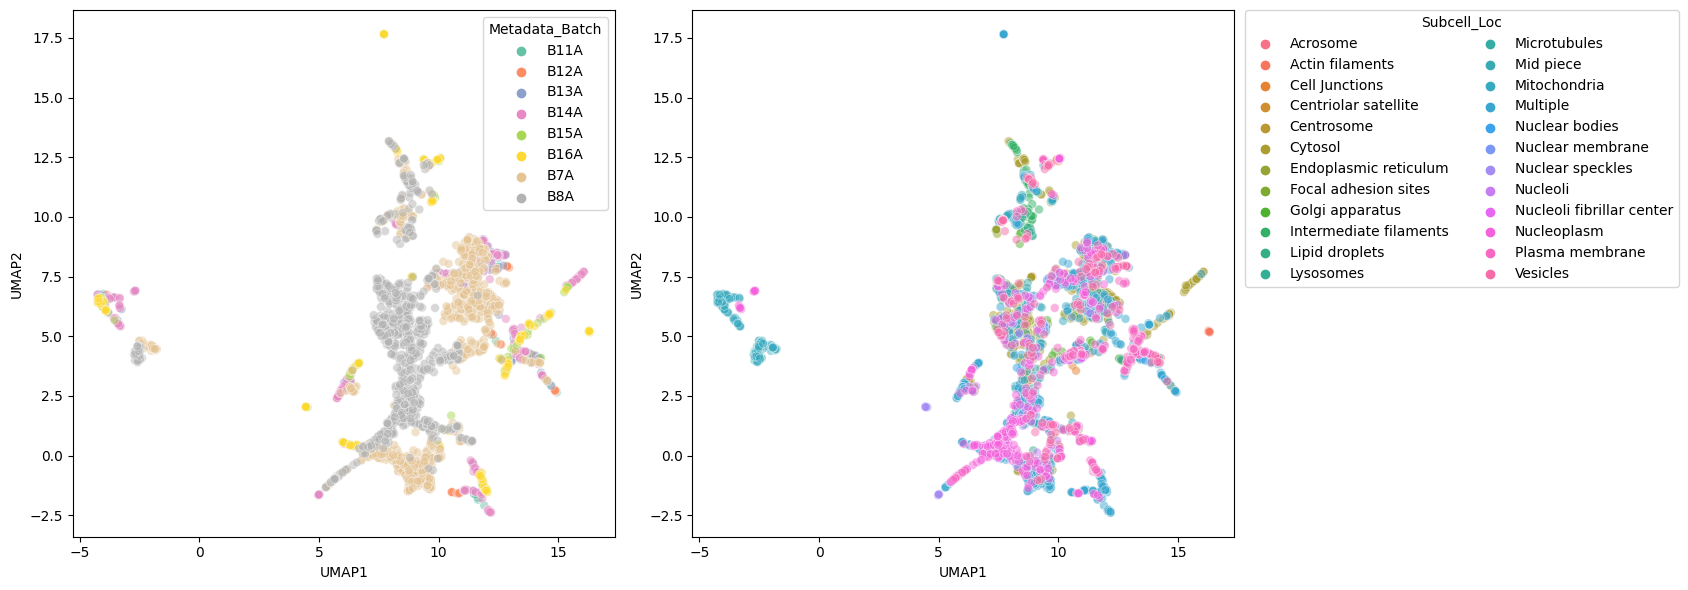

In [62]:
# Plot UMAP
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
sns.scatterplot(data=umap_df.sort_values(by="Metadata_Batch"), alpha=.5,
                x="UMAP1", y="UMAP2", hue="Metadata_Batch", palette="Set2", s=40, ax=ax[0]) ## hue=variant_type, 
sns.scatterplot(data=umap_df.sort_values(by="Subcell_Loc"), alpha=.5,
                x="UMAP1", y="UMAP2", hue="Subcell_Loc", 
                palette=sns.color_palette("husl", len(red_allele_well_profile_df_hpa["Subcell_Loc"].unique())), s=40, ax=ax[1]) ## hue=variant_type, 
ax[1].legend(ncol=2, title="Subcell_Loc",
             loc="upper left",
             bbox_to_anchor=(1.02, 1.0),
             borderaxespad=0)

# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
# ax.set_title("UMAP Plot")
# ax.set_xlabel("UMAP1")
# ax.set_ylabel("UMAP2")
plt.tight_layout()
plt.show()

In [65]:
umap_df[(umap_df["UMAP1"]<0)].groupby("Subcell_Loc").count()

,UMAP1,UMAP2,Metadata_Batch,Metadata_gene_allele
Subcell_Loc,,,,
Mitochondria,218,218,218,218
Nucleoplasm,16,16,16,16


In [68]:
umap_df[(umap_df["UMAP1"]<0)].groupby(["Metadata_gene_allele","Subcell_Loc"]).count()

,,UMAP1,UMAP2,Metadata_Batch
Metadata_gene_allele,Subcell_Loc,,,
FANCC,Nucleoplasm,8,8,8
RPS19,Nucleoplasm,8,8,8
SDHAF1,Mitochondria,7,7,7
SLIRP,Mitochondria,211,211,211
